In [27]:
# Takes a long time to download (1.6GB)
#import gensim.downloader as api

#print(api.info())

#model = api.load("word2vec-google-news-300")


In [28]:
import re
import numpy as np
import pandas as pd
import gensim.downloader as api
from tqdm import tqdm 
import os

In [29]:
# pre processing function 
def preprocess_text(text):
    if pd.isnull(text):
        return []
    # lowercase the text
    text = text.lower()
    
    # remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # tokenize (split into words)
    tokens = text.split()

    return tokens

In [30]:
# sentence embedding generator by averaging word vectors for each token
from sklearn.preprocessing import normalize

def get_word2vec_embeddings(tokens, model):
    word_vectors = []
    for word in tokens:
        if word in model:
            word_vectors.append(model[word])
        
    
    if word_vectors:
        # compute the mean of all word vectors
        sentence_embedding = np.mean(word_vectors, axis=0)
        sentence_embedding = normalize(sentence_embedding.reshape(1, -1)).flatten()  # Normalize
    else:
        # if there are no valid words return a vector of zeros
        sentence_embedding = np.zeros(model.vector_size)
    
    return sentence_embedding

In [31]:
print("Available models:")
print(api.info()['models'].keys())

Available models:
dict_keys(['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis'])


In [32]:
# choosed a smaller model to save time and space
model_name = "glove-wiki-gigaword-50"  # 70MB

# load the model
model = api.load(model_name)

In [33]:
# TEST RUN WITH EXAMPLE WORDS FOR TESTING WORD AND SENTENCE EMBEDDINGS
# # example words
# words = ["arda", "asmi", "paige", "tanisha", "rebecca", "vaishnavi"]
# for word in words:
#     embedding = model[word]
#     print(f"Embedding for '{word}':")
#     print(embedding)
#     print(embedding.shape)
# # Example of preprocessing and generating sentence embedding
# sample_text = "american express team 1 is the best team"
# tokens = preprocess_text(sample_text)
# print(f"preprocessed tokens: {tokens}")

# sentence_embedding = get_word2vec_embeddings(tokens, model)
# print(sentence_embedding.shape)
# print(f"Sentence embedding: {sentence_embedding}")


In [34]:
input_path = "../data/products.csv"
output_path = "../data/brand_embeddings.csv"
chunk_size = 10000
embeddings_list = []

In [35]:
with pd.read_csv(input_path, chunksize=chunk_size) as reader:
        for chunk_number, chunk in enumerate(tqdm(reader, desc="Processing Chunks")):
            # preprocess name column
            chunk['tokens'] = chunk['brand'].apply(preprocess_text)
            
            # sentence embeddings
            embeddings = chunk['tokens'].apply(lambda tokens: get_word2vec_embeddings(tokens, model))
            
            # convert embeddings to lists for storing in df
            embeddings = embeddings.apply(lambda x: x.tolist())
            
            embeddings_df = pd.DataFrame({
                'brand': chunk['brand'],
                'brand_embedding': embeddings
            })
            
            # Save 
            if chunk_number == 0:
                # header for the first chunk
                embeddings_df.to_csv(output_path, index=False, mode='w')
            else:
                # no header for the rest
                embeddings_df.to_csv(output_path, index=False, header=False, mode='a')
            
            # free memory
            del chunk['tokens']
            del embeddings
            del embeddings_df


Processing Chunks: 3it [00:02,  1.26it/s]


Embedding K-Means Clustering

In [46]:
from sklearn.cluster import KMeans
import ast

def cluster_embeddings(output_path, n_clusters=10):
    df = pd.read_csv(output_path)
    embeddings = np.stack(df['brand_embedding'].apply(ast.literal_eval))
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    df['cluster'] = kmeans.fit_predict(embeddings)
    df.to_csv(output_path, index=False)  # Save updated file
    print("Clustering completed. Clusters saved to file.")
    return kmeans, embeddings, df

kmeans, embeddings, df = cluster_embeddings('../data/brand_embeddings.csv')

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Clustering completed. Clusters saved to file.


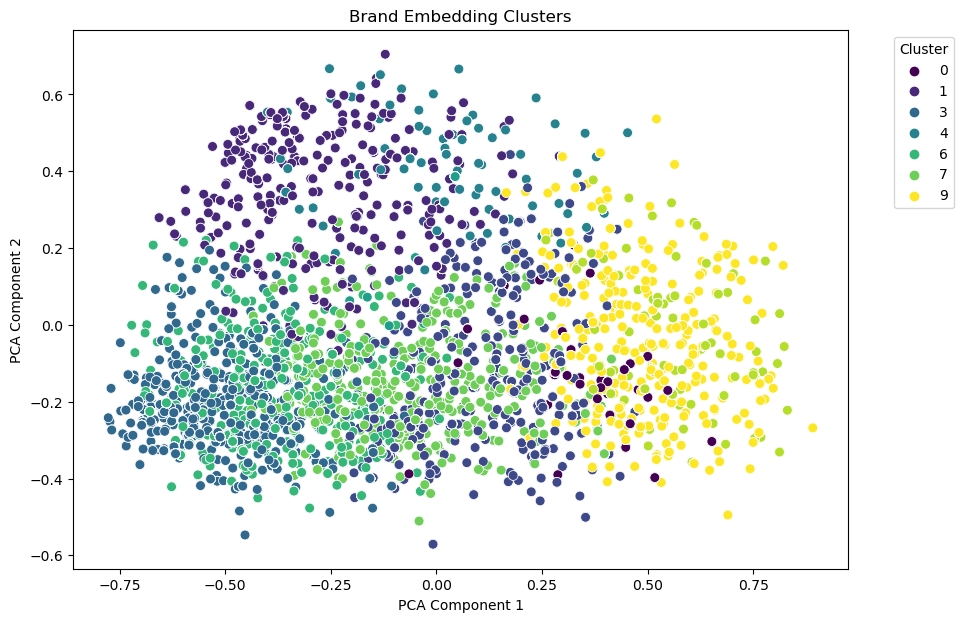

In [47]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)
plt.figure(figsize=(10, 7))
sns.scatterplot(x=reduced_embeddings[:, 0], y=reduced_embeddings[:, 1], hue=df['cluster'], palette='viridis', s=50)
plt.title('Brand Embedding Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [48]:
from sklearn.metrics import silhouette_score

# Assuming `embeddings` and `kmeans.labels_` are available
silhouette_avg = silhouette_score(embeddings, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.194121627167681


In [50]:
top_brands_by_cluster = df.groupby('cluster')['brand'].value_counts().groupby(level=0).head(3)
print(top_brands_by_cluster)

cluster  brand               
0        Quiksilver               257
         Dockers                  220
         Speedo                   196
1        Champion                 178
         Fox                      138
         HUGO BOSS                134
2        Diesel                   218
         FineBrandShop            170
         SmartWool                161
3        7 For All Mankind        176
         True Religion            141
         Fruit of the Loom        136
4        Calvin Klein             497
         Tommy Hilfiger           251
         Hurley                   231
5        Allegra K               1034
         Tiana B                    7
         Aryn K                     6
6        Columbia                 236
         American Apparel         193
         Jones New York           150
7        Motherhood Maternity     185
         Lucky Brand              172
         Joe's Jeans              110
8        Carhartt                 388
         Hanes      

AttributeError: 'numpy.int64' object has no attribute 'startswith'

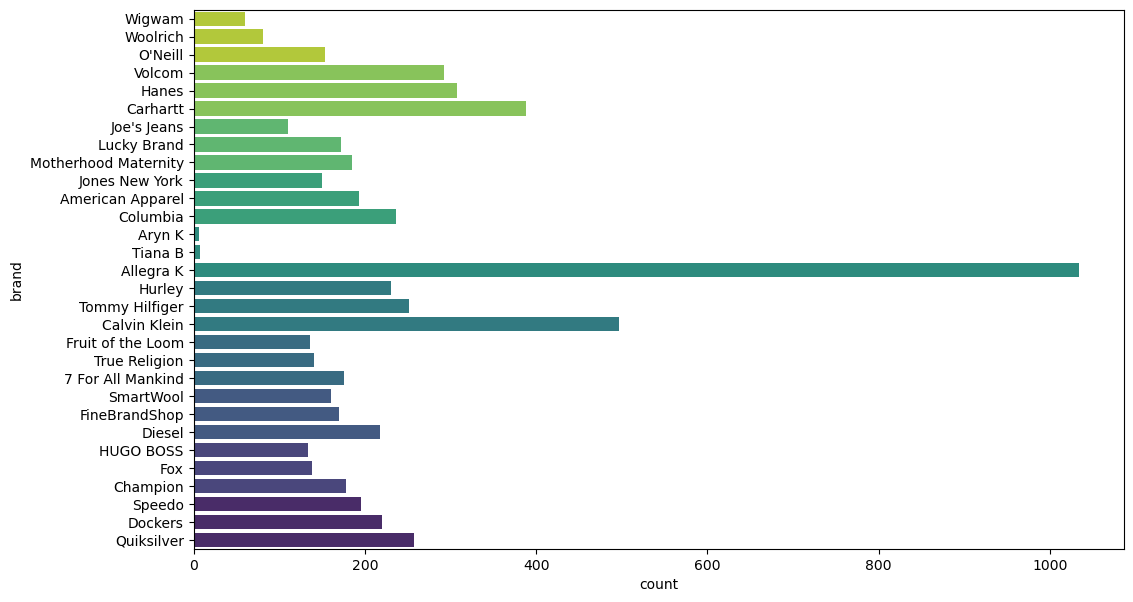

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the occurrences of each brand in each cluster
top_brands = (
    df.groupby(['cluster', 'brand'])
    .size()
    .reset_index(name='count')
    .sort_values(['cluster', 'count'], ascending=[True, False])
)

# Keep only the top 3 brands for each cluster
top_brands = top_brands.groupby('cluster').head(3)

# Plot the top brands
plt.figure(figsize=(12, 7))
sns.barplot(
    x='count',
    y='brand',
    hue='cluster',
    data=top_brands,
    dodge=False,  # Merge bars for the same cluster
    palette='viridis'
)
plt.title('Top 3 Brands for Each Cluster')
plt.xlabel('Count')
plt.ylabel('Brand')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

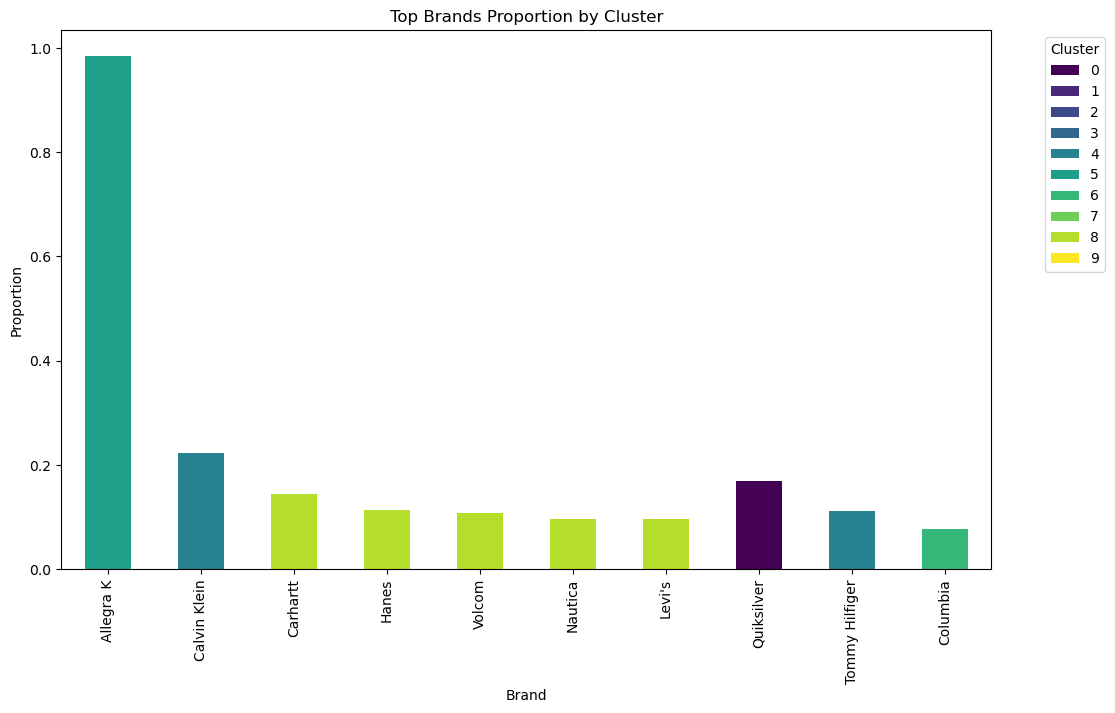

In [61]:
# Aggregate data for stacked bar chart
stacked_data = (
    df.groupby(['cluster', 'brand'])
    .size()
    .reset_index(name='count')
    .sort_values(['cluster', 'count'], ascending=[True, False])
)

# Normalize to show proportions within each cluster
stacked_data['proportion'] = stacked_data.groupby('cluster')['count'].transform(lambda x: x / x.sum())

# Pivot the data for plotting
stacked_pivot = stacked_data.pivot(index='brand', columns='cluster', values='proportion').fillna(0)

# Select top brands for better visualization
top_brands = stacked_data.groupby('brand')['count'].sum().nlargest(10).index
stacked_pivot = stacked_pivot.loc[top_brands]

# Plot stacked bar chart
stacked_pivot.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 7),
    colormap='viridis'
)
plt.title('Top Brands Proportion by Cluster')
plt.xlabel('Brand')
plt.ylabel('Proportion')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()